<a href="https://colab.research.google.com/github/lucascheng24/COMP4432ML-DataProduct-A_Million_News_Headlines/blob/main/analysis_topicModeling_LDA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#reference to https://www.kaggle.com/code/rcushen/topic-modelling-with-lsa-and-lda

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [3]:
# Load the data file
url = 'https://raw.githubusercontent.com/lucascheng24/COMP4432ML-DataProduct-A_Million_News_Headlines/main/raw_data/abcnews-date-text.csv'

raw_data = pd.read_csv(url, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head(10)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers
5,2003-02-19,ambitious olsson wins triple jump
6,2003-02-19,antic delighted with record breaking barca
7,2003-02-19,aussie qualifier stosur wastes four memphis match
8,2003-02-19,aust addresses un security council over iraq
9,2003-02-19,australia is locked into war timetable opp


In [4]:
# Sample size
sampleSize = len(raw_data) // 20   # 5%
analyze_random_state = 4432

print("sampleSize: ", sampleSize)

sampleSize:  62209


In [5]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=20000)
small_text_sample = reindexed_data.sample(n = sampleSize, random_state = analyze_random_state).values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

type(small_document_term_matrix), small_document_term_matrix.shape

(scipy.sparse._csr.csr_matrix, (62209, 20000))

In [6]:
n_topics = 10

In [7]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [8]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [9]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [10]:
# This is standard descriptive analysis where we show the most common words for each topic
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  interview nsw coronavirus country report covid nt pm hour hill
Topic 2:  crash australia man killed road government funding change canberra death
Topic 3:  govt water plan urged rural industry talks changes abc defends
Topic 4:  day sydney south national set school house china plans news
Topic 5:  court wa qld election accused man farmers indigenous wins group
Topic 6:  new health win trial dead concerns safety review police search
Topic 7:  world queensland centre guilty hit budget business family drought work
Topic 8:  police says coast attack missing north man death gold minister
Topic 9:  australian car council year calls melbourne dies claims charges drug
Topic 10:  man charged murder hospital home sa cup market deal test


Text(0, 0.5, 'Number of headlines')

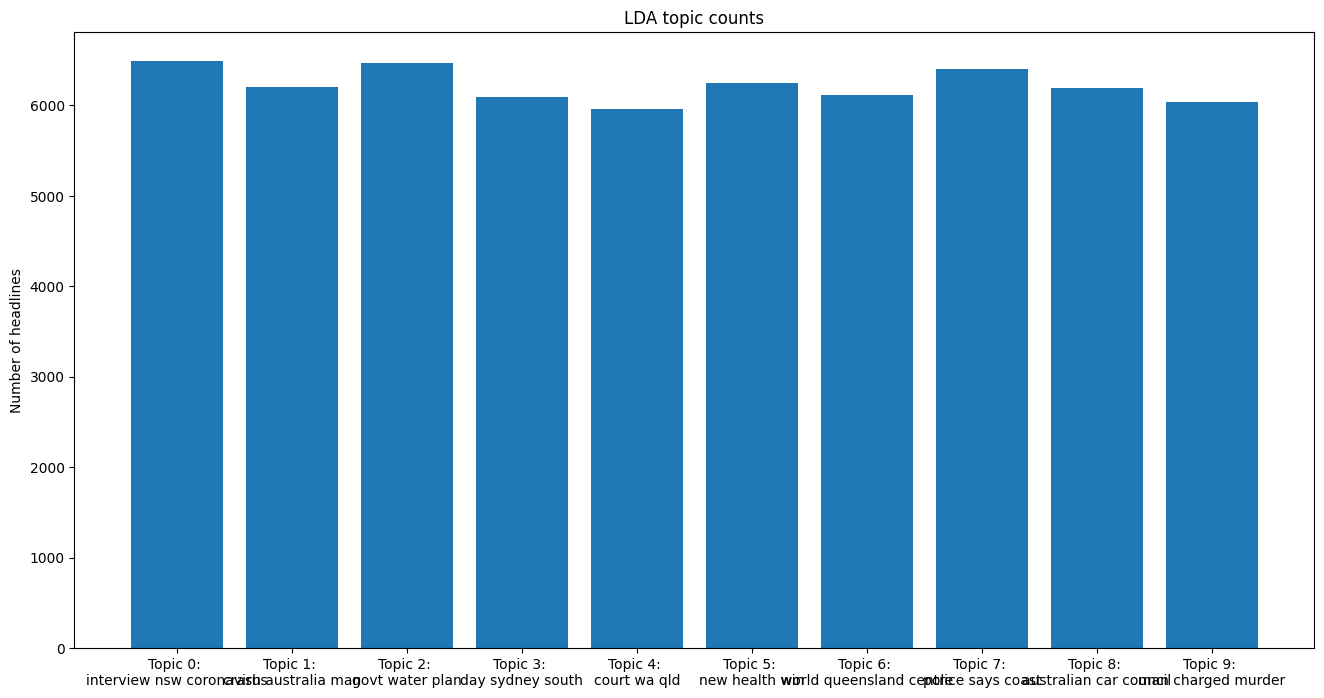

In [11]:
# Label each topic with its top three words.
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of headlines')

In [25]:
top_3_words

['interview nsw coronavirus',
 'crash australia man',
 'govt water plan',
 'day sydney south',
 'court wa qld',
 'new health win',
 'world queensland centre',
 'police says coast',
 'australian car council',
 'man charged murder']

In [12]:
# Instantiate the model
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)

In [13]:
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 62209 samples in 0.092s...
[t-SNE] Computed neighbors for 62209 samples in 36.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 62209
[t-SNE] Computed conditional probabilities for sample 2000 / 62209
[t-SNE] Computed conditional probabilities for sample 3000 / 62209
[t-SNE] Computed conditional probabilities for sample 4000 / 62209
[t-SNE] Computed conditional probabilities for sample 5000 / 62209
[t-SNE] Computed conditional probabilities for sample 6000 / 62209
[t-SNE] Computed conditional probabilities for sample 7000 / 62209
[t-SNE] Computed conditional probabilities for sample 8000 / 62209
[t-SNE] Computed conditional probabilities for sample 9000 / 62209
[t-SNE] Computed conditional probabilities for sample 10000 / 62209
[t-SNE] Computed conditional probabilities for sample 11000 / 62209
[t-SNE] Computed conditional probabilities for sample 12000 / 62209
[t-SNE] Computed conditional probabilities for s

In [16]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [17]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color="black")
    plot.add_layout(label)

show(plot)